# =========================
# PART A: CLASSICAL APPROACH
# Action Recognition (UCF-101 3-class subset)
# =========================

# This notebook demonstrates the classical machine learning approach
# for action recognition in videos using hand-crafted features.
# Features include:
# 1. Color features (RGB/HSV histograms, color moments)
# 2. Texture features (GLCM, LBP)
# 3. Shape features (HOG, edge histograms)
# 4. Motion features (Frame differencing, Optical Flow)
# 5. Temporal features (mean, std, frame-to-frame variation)

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
# -------------------------
# IMPORT LIBRARIES
# -------------------------
import os
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Custom feature extraction module
from feature_extraction import extract_video_features


In [3]:
# -------------------------
# CONFIGURATION
# -------------------------

# Root folder (assuming notebook is in /code/)
ROOT = Path.cwd().parent
DATASET_DIR = ROOT / "dataset"
SPLITS_DIR = DATASET_DIR / "splits"

# Classes used in this subset
CLASSES = ["Basketball", "Biking", "WalkingWithDog"]
CLASS_MAPPING = {cls: idx for idx, cls in enumerate(CLASSES)}

print("Classes and labels:", CLASS_MAPPING)

# Note:
# CLASSES can be renamed or changed, but ensure they match the folder names in dataset


Classes and labels: {'Basketball': 0, 'Biking': 1, 'WalkingWithDog': 2}


In [4]:
# -------------------------
# HELPER FUNCTIONS
# -------------------------

def load_split(split_file):
    """
    Load a split (train/val/test) from a text file.
    Returns a list of tuples: (video_path, label)
    """
    data = []
    with open(split_file, "r") as f:
        for line in f.readlines():
            line = line.strip()
            cls_name = line.split("/")[0]
            label = CLASS_MAPPING[cls_name.split("_")[-1]]
            video_path = DATASET_DIR / line
            data.append((video_path, label))
    return data


def extract_features_for_split(split_data):
    """
    Extract features for all videos in a split using extract_video_features.
    Returns:
        X: np.array of feature vectors
        y: np.array of labels
    """
    X, y = [], []
    for video_path, label in split_data:
        feat = extract_video_features(str(video_path))
        X.append(feat)
        y.append(label)
    return np.array(X), np.array(y)


In [5]:
# -------------------------
# LOAD TRAIN/VAL/TEST SPLITS
# -------------------------
# Load text files generated during dataset preparation
train_data = load_split(SPLITS_DIR / "train.txt")
val_data   = load_split(SPLITS_DIR / "val.txt")
test_data  = load_split(SPLITS_DIR / "test.txt")

print(f"Number of videos -> Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")


Number of videos -> Train: 106, Val: 22, Test: 24


In [6]:
# -------------------------
# FEATURE EXTRACTION
# -------------------------

# Training features
print("🚀 Extracting features for training set...")
X_train, y_train = extract_features_for_split(train_data)
print("✅ Training features shape:", X_train.shape)

# Validation features
print("🚀 Extracting features for validation set...")
X_val, y_val = extract_features_for_split(val_data)
print("✅ Validation features shape:", X_val.shape)

# Test features
print("🚀 Extracting features for test set...")
X_test, y_test = extract_features_for_split(test_data)
print("✅ Test features shape:", X_test.shape)

# Note:
# Feature extraction may take time depending on number of videos and video length


🚀 Extracting features for training set...
✅ Training features shape: (106, 17360)
🚀 Extracting features for validation set...
✅ Validation features shape: (22, 17360)
🚀 Extracting features for test set...
✅ Test features shape: (24, 17360)


In [7]:
# -------------------------
# TRAIN SVM CLASSIFIER
# -------------------------

# Using Linear SVM as classical classifier
print("🚀 Training Linear SVM classifier...")
clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)
print("✅ Training complete")


🚀 Training Linear SVM classifier...
✅ Training complete


🎯 Test Accuracy: 79.17%


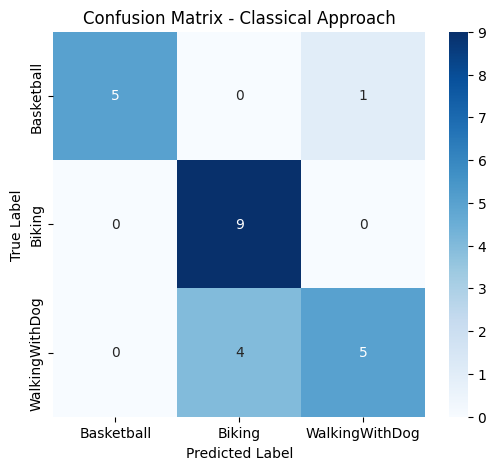

📊 Classification Report:
                 precision    recall  f1-score   support

    Basketball       1.00      0.83      0.91         6
        Biking       0.69      1.00      0.82         9
WalkingWithDog       0.83      0.56      0.67         9

      accuracy                           0.79        24
     macro avg       0.84      0.80      0.80        24
  weighted avg       0.82      0.79      0.78        24



In [8]:
# -------------------------
# EVALUATE CLASSIFIER
# -------------------------

# Predict on test set
y_pred = clf.predict(X_test)

# Accuracy
acc = np.mean(y_pred == y_test)
print(f"🎯 Test Accuracy: {acc*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=CLASSES, yticklabels=CLASSES, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Classical Approach")
plt.show()

# Detailed classification report
report = classification_report(y_test, y_pred, target_names=CLASSES)
print("📊 Classification Report:\n", report)


In [9]:
# -------------------------
# SAVE FEATURES AND SPLITS (OPTIONAL)
# -------------------------
np.save(DATASET_DIR / "X_train.npy", X_train)
np.save(DATASET_DIR / "y_train.npy", y_train)
np.save(DATASET_DIR / "X_val.npy", X_val)
np.save(DATASET_DIR / "y_val.npy", y_val)
np.save(DATASET_DIR / "X_test.npy", X_test)
np.save(DATASET_DIR / "y_test.npy", y_test)

print("💾 Features and split arrays saved for future use.")


💾 Features and split arrays saved for future use.


# 📝 Summary

**Classical Approach - Action Recognition (Part A)**

- **Dataset:** 3-class subset of UCF-101 manually prepared  
- **Features Used:** Color (HSV histograms), Shape (HOG), Motion (Frame differencing / Optical flow), Temporal features  
- **Classifier:** Linear SVM  
- **Evaluation Metrics:** Accuracy, Confusion Matrix, Classification Report  
- **Output:** Saved `.npy` files for train/val/test features and labels  

**Next Steps:**
- Use these features for comparative analysis in `comparative_analysis.ipynb`
- For deep learning approach (Part B), feed videos directly into a CNN or 3D-CNN model.
